# Proyek Akhir : Image Classification Model Deployment

Nama: Kemal Adam Roisy

Email: kemal.adam@sci.ui.ac.id

## Kriteria Submission


1.   Dataset yang akan dipakai bebas, namun minimal memiliki 1000 buah gambar.
2.   Dataset dibagi menjadi 80% train set dan 20% test set.
3.   Model harus menggunakan model sequential.
4.   Model harus menggunakan Conv2D Maxpooling Layer.
5.   Akurasi pada training dan validation set minimal sebesar 80%.
6.   Menggunakan Callback.
7.   Membuat plot terhadap akurasi dan loss model.
8.   Menulis kode untuk menyimpan model ke dalam format TF-Lite.



# Dataset Download

Dataset: Fresh and Stale Images of Fruits and Vegetables
url: https://www.kaggle.com/raghavrpotdar/fresh-and-stale-images-of-fruits-and-vegetables

In [1]:
# Install kaggle package to use API

!pip install -q kaggle

In [2]:
# Upload kaggle.json API Token

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kemaladamr","key":"315f8636beaccfe56af5b9fe74bdbfb2"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d raghavrpotdar/fresh-and-stale-images-of-fruits-and-vegetables

100% 1.41G/1.41G [00:13<00:00, 105MB/s]
100% 1.41G/1.41G [00:13<00:00, 112MB/s]


# Import Library and Dependencies

In [5]:
import zipfile
import os, re

import pandas as pd
import random

import tensorflow as tf
from sklearn.model_selection import train_test_split 
from keras.preprocessing.image import ImageDataGenerator

# from tensorflow.keras.optimizers import RMSprop
from keras.optimizers import Adam
from tensorflow.keras import regularizers

from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np

In [6]:
# lokasi data
base_dir = "/content"

# Kelas klasifikasi mendefinisikan nilai 12 kelas
NUM_CLASS = 12

In [7]:
# Semakin tinggi ukuran resolusi gambar tidak meningkatkan hasil akurasi training

IMAGE_WIDTH = 224  
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

BATCH_SIZE=32

In [8]:
!mkdir _dataset

In [9]:
local_zip = os.path.join(base_dir, 'fresh-and-stale-images-of-fruits-and-vegetables.zip')
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('_dataset')
zip_ref.close()

In [10]:
!rm -rf /content/_dataset/ImageLabels.txt
!rm -rf /content/fresh-and-stale-images-of-fruits-and-vegetables.zip

In [11]:
base_dir = os.path.join(base_dir, '_dataset')

In [12]:
categories = []
for category in (os.listdir(base_dir)):
    locals()[category + "_dir"] = os.path.join(base_dir, category)
    categories.append(category)

print(categories)
print('\n')
print(fresh_banana_dir)

['fresh_bitter_gourd', 'fresh_apple', 'fresh_capsicum', 'stale_capsicum', 'fresh_orange', 'stale_banana', 'stale_orange', 'stale_bitter_gourd', 'stale_apple', 'fresh_banana', 'fresh_tomato', 'stale_tomato']


/content/_dataset/fresh_banana


In [13]:
# Check total of data and sampling data
%matplotlib inline
def show_sample(path):
    ncols, nrows = 4, 3
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 3)
    # figsize = [8, 6]
    # fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    for i, category in enumerate(os.listdir(path)):
        fname = random.choice(os.listdir(os.path.join(path, category)))
        
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off')

        img = mpimg.imread(os.path.join(path, category, fname))
        plt.imshow(img)

    plt.show()


In [14]:
def count_data(path):
    total = 0
    for category in os.listdir(path):
        count = len(os.listdir(os.path.join(path, category)))
        print(category + ': ' + str(count))
        total += count

    print('\nTotal: ' + str(total))

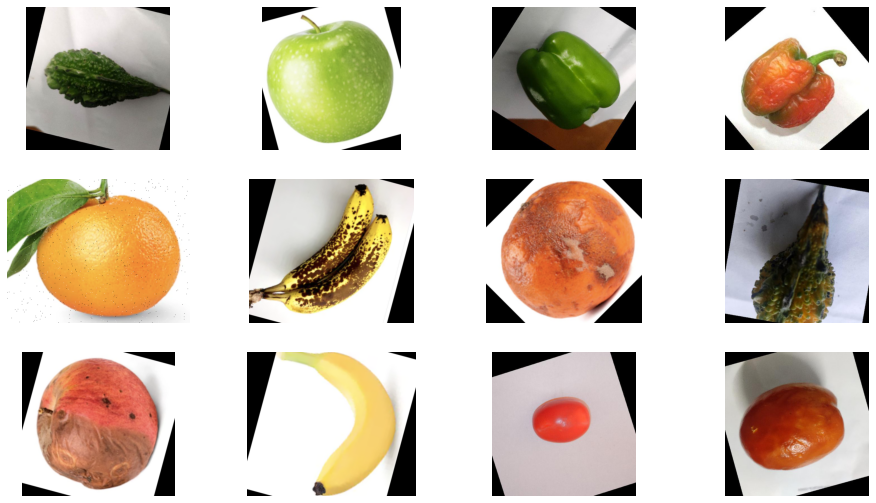

In [15]:
show_sample(base_dir)

In [16]:
count_data(base_dir)

fresh_bitter_gourd: 327
fresh_apple: 1693
fresh_capsicum: 990
stale_capsicum: 901
fresh_orange: 1466
stale_banana: 1467
stale_orange: 1595
stale_bitter_gourd: 357
stale_apple: 2342
fresh_banana: 1581
fresh_tomato: 981
stale_tomato: 982

Total: 14682


In [17]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    shear_range=.2,
    horizontal_flip=True,
    validation_split=0.2
    )

validation_data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
    )

In [18]:
train_generator = train_data_generator.flow_from_directory(
                base_dir,
                target_size=IMAGE_SIZE,
                batch_size=BATCH_SIZE,
                color_mode='rgb',
                class_mode='categorical',
                shuffle=True,
                subset='training',
                seed=42)

validation_generator = validation_data_generator.flow_from_directory(
                    base_dir,
                    target_size=IMAGE_SIZE,
                    batch_size=BATCH_SIZE,
                    color_mode='rgb',
                    class_mode='categorical',
                    shuffle=True,
                    subset='validation',
                    seed=42)

Found 11749 images belonging to 12 classes.
Found 2933 images belonging to 12 classes.


In [19]:
model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        # tf.keras.layers.Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),
        #                         activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006),
        #                         activation='relu'),
        tf.keras.layers.Dense(256, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                bias_regularizer=regularizers.l2(1e-4),
                                activity_regularizer=regularizers.l2(1e-5), activation='relu'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(NUM_CLASS, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 8)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 111, 111, 8)       32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      2336      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [21]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.93 and logs.get('val_accuracy')>0.93):
      self.model.stop_training = True
      print("\n Great! The accuracy from training and validation set is already reach > 93%.")

callbacks = myCallback()

In [22]:
history = model.fit(train_generator, 
                    steps_per_epoch=25, 
                    epochs=100, 
                    validation_data=validation_generator,
                    validation_steps=5,
                    verbose=1,
                    callbacks=callbacks,
                    # batch_size=512
                    )

Epoch 1/100
25/25 [==============================] - 44s 487ms/step - loss: 2.4753 - accuracy: 0.1675 - val_loss: 2.4475 - val_accuracy: 0.3063
Epoch 2/100
25/25 [==============================] - 11s 451ms/step - loss: 1.9904 - accuracy: 0.3790 - val_loss: 2.3849 - val_accuracy: 0.1937
Epoch 3/100
25/25 [==============================] - 12s 495ms/step - loss: 1.6788 - accuracy: 0.4625 - val_loss: 2.4052 - val_accuracy: 0.2438
Epoch 4/100
25/25 [==============================] - 12s 491ms/step - loss: 1.4550 - accuracy: 0.5275 - val_loss: 2.2442 - val_accuracy: 0.2375
Epoch 5/100
25/25 [==============================] - 11s 443ms/step - loss: 1.3766 - accuracy: 0.5705 - val_loss: 1.8772 - val_accuracy: 0.3938
Epoch 6/100
25/25 [==============================] - 11s 455ms/step - loss: 1.2394 - accuracy: 0.6100 - val_loss: 1.5202 - val_accuracy: 0.5875
Epoch 7/100
25/25 [==============================] - 12s 501ms/step - loss: 1.1243 - accuracy: 0.6075 - val_loss: 1.3724 - val_accuracy:

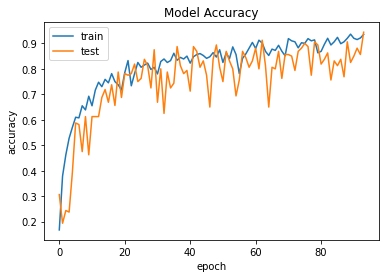

In [23]:
# plot of accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

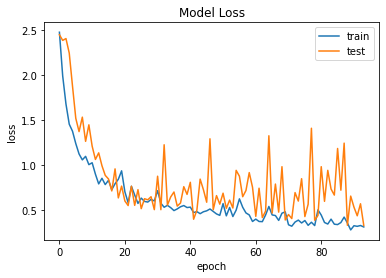

In [24]:
# plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpxh_lpp4d/assets


INFO:tensorflow:Assets written to: /tmp/tmpxh_lpp4d/assets
